In [1]:
from __future__ import print_function, division, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sns
from oddt.shape import *
from oddt.metrics import *
from oddt.datasets import *
import matplotlib.pyplot as plt
from scipy.spatial import distance
from joblib import Parallel, delayed

%matplotlib inline

In [2]:
import oddt
print(oddt.__version__)

0.4.1-11-g0f2e5fe


In [3]:
def dude_usr(target, usr_method):
    """Computes enrichment factor and area under the ROC curve for dude target
    
    Parameters
    ----------
    target : class oddt.datasets._dude_target object
        Target from DUD-E (A Database of Useful Decoys: Enhanced)
        
    usr_method: str
        usr, usr_cat or electroshape
        
    Returns
    -------
    data : pd.DataFrame
        Inside: target id, enrichment factor, roc auc, usr method 
    
    """
    
    if usr_method == 'usr':
        usr_function = usr 
    elif usr_method == 'usr_cat':
        usr_function = usr_cat
    elif usr_method == 'electroshape':
        usr_function = electroshape
    else:
        raise Exception('Wrong usr method')
    
    similarity_function = usr_similarity
    
    usr_actives = np.array([usr_function(mol) for mol in target.actives])
    usr_decoys = np.array([usr_function(mol) for mol in target.decoys])
        
    sim = distance.cdist(usr_actives, np.vstack((usr_actives, usr_decoys)), 
                         metric=similarity_function)
    
    act = np.ones(len(usr_actives))
    dec = np.zeros(len(usr_decoys))
    act_dec = np.append(act, dec)
    
    usr_enr_factor = []
    usr_roc_auc = []

    for row in sim:
        
        similar_act = np.matrix((row, act_dec))
        similar_act = pd.DataFrame(similar_act.T)
        similar_act = similar_act.sort_values(0, ascending=False)
        similar_act = similar_act[1:]
    
        usr_enr_factor.append(enrichment_factor(y_true = similar_act[1].values, 
                                                y_score = similar_act[0].values))
        usr_roc_auc.append(roc_auc(y_true = similar_act[1].values, 
                                   y_score = similar_act[0].values, 
                                   ascending_score=False))

    
    data = pd.DataFrame({'target id': target.dude_id, 'ef1': usr_enr_factor,
                         'roc': usr_roc_auc, 'usr type': usr_method})
    return pd.DataFrame(data)


In [4]:
path = '/home/paulina/Datasets/DUDE/' # Path to files from dud-e
# I used only 10 targets: 'fgfr1', 'ampc', 'comt', 'fabp4', 'glcm', 'inha', 'kith', 'pygm', 'sahh', 'cxcr4'

<center><h3>DUD-E: <a href=http://dude.docking.org/>http://dude.docking.org/</a></h3></center>

In [5]:
data = Parallel(n_jobs=10, verbose=10)(delayed(dude_usr)(target, usr_method) 
                                       for target in dude(path) 
                                       for usr_method in ['usr', 'usr_cat', 'electroshape'])

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done  15 out of  30 | elapsed:  2.3min remaining:  2.3min
[Parallel(n_jobs=10)]: Done  19 out of  30 | elapsed:  2.6min remaining:  1.5min
[Parallel(n_jobs=10)]: Done  23 out of  30 | elapsed:  2.8min remaining:   51.7s
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed:  2.9min remaining:   19.4s
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:  3.0min finished


In [6]:
data = pd.concat(data)

data_usr = data[data['usr type'] == 'usr']
data_usr.to_csv('dude_usr.csv')

data_usr_cat = data[data['usr type'] == 'usr_cat']
data_usr_cat.to_csv('dude_usr_cat.csv')

data_electro = data[data['usr type'] == 'electroshape']
data_electro.to_csv('dude_electro.csv')

<h3><center>USR</center></h3>

In [7]:
data_usr.head(5)

,ef1,roc,target id,usr type
0,1.752212,0.565337,pygm,usr
1,6.132743,0.530166,pygm,usr
2,2.628319,0.556999,pygm,usr
3,8.761062,0.560821,pygm,usr
4,4.380531,0.525578,pygm,usr


In [8]:
data_usr.groupby('target id').mean().mean()

ef1    5.543430
roc    0.619255
dtype: float64

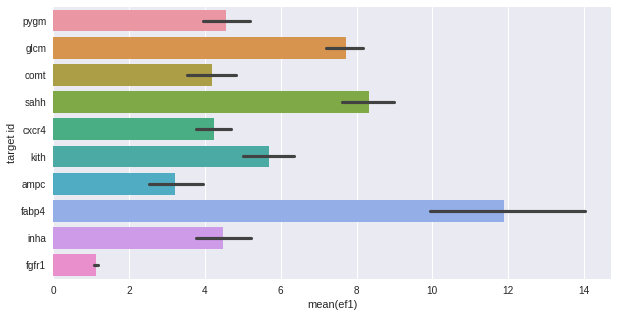

In [9]:
plt.figure(figsize=(10,5))
sns.barplot(y = 'target id', x = 'ef1', data = data_usr)

<h3><center>USR CAT</center></h3>

In [10]:
data_usr_cat.head(5)

,ef1,roc,target id,usr type
0,10.513274,0.587687,pygm,usr_cat
1,9.637168,0.595062,pygm,usr_cat
2,19.274336,0.605255,pygm,usr_cat
3,15.769912,0.614586,pygm,usr_cat
4,10.513274,0.579258,pygm,usr_cat


In [11]:
data_usr_cat.groupby('target id').mean().mean()

ef1    10.656478
roc     0.655287
dtype: float64

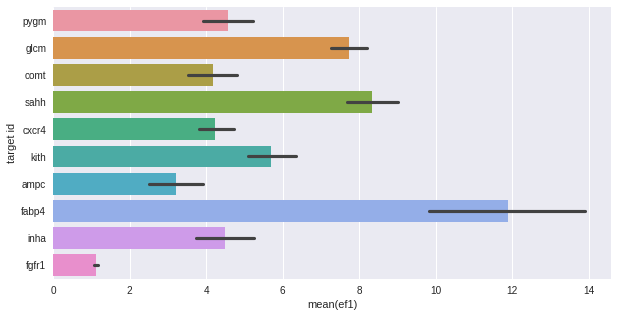

In [12]:
plt.figure(figsize=(10,5))
sns.barplot(y = 'target id', x = 'ef1', data = data_usr)

<h3><center>ELECTROSHAPE</center></h3>

In [13]:
data_electro.head(5)

,ef1,roc,target id,usr type
0,15.769912,0.758636,pygm,electroshape
1,12.265487,0.806240,pygm,electroshape
2,14.893805,0.856232,pygm,electroshape
3,17.522124,0.846134,pygm,electroshape
4,12.265487,0.804356,pygm,electroshape


In [14]:
data_electro.groupby('target id').mean().mean()

ef1    12.388775
roc     0.729570
dtype: float64

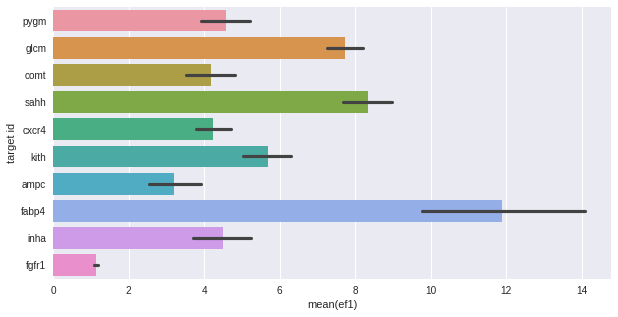

In [15]:
plt.figure(figsize=(10,5))
sns.barplot(y = 'target id', x = 'ef1', data = data_usr)